<a href="https://colab.research.google.com/github/alizul01/2141720088-PCVK-2023/blob/main/week_11_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection

Method we use
1. Template Matching
2. Edge Detection
3. Corner Detection
4. Grid Detection
5. Contour Detection

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from google.colab.patches import cv2_imshow

## Method Area

In [2]:
def load_image(file_path):
    img = cv2.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def compare_images(original, processed, title_before='Original', title_after='Processed', cmap=None):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap=cmap)
    plt.title(title_before)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap=cmap)
    plt.title(title_after)
    plt.axis('off')

def apply_edge_detection(image, method):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray, (3, 3), 0)

    if method == 'sobel':
        img_sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        img_sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        edge_image = cv2.addWeighted(cv2.convertScaleAbs(img_sobelx), 0.5, cv2.convertScaleAbs(img_sobely), 0.5, 0)
    elif method == 'canny':
        edge_image = cv2.Canny(img, 100, 200)
    elif method == 'laplacian':
        edge_image = cv2.Laplacian(img, cv2.CV_64F)
        edge_image = cv2.convertScaleAbs(edge_image)
    else:
        edge_image = img

    return edge_image

def plot_images_with_titles(images, titles):
    num_images = len(images)
    if num_images != len(titles):
        raise ValueError("Number of images and titles must match.")

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

def sum_of_squared_differences(image, template):
    I, T = image.astype('float'),template.astype('float')
    H, W = I.shape[0], I.shape[1]
    h, w = T.shape[0], T.shape[1]
    R = np.ones_like(image)*np.inf

    for i in range(W-w):
        for j in range(H-h):
            t = (I[j: j+h, i: i+w] - T).ravel()
            R[j, i] = t.dot(t)

    return R

def template_matching(image, template):
    R = sum_of_squared_differences(image, template)
    _, _, min_loc, max_loc = cv2.minMaxLoc(-R)
    top_left = max_loc
    h,w = template.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)
    return R, top_left,bottom_right

def plot_image(map_puzzle,top_left,bottom_right):
  region_of_interest = map_puzzle[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]
  mask = np.zeros(map_puzzle.shape, dtype = "uint8")
  image_map = cv2.addWeighted(map_puzzle, 0.3, mask, 0.7, 0)
  image_map[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]] = region_of_interest
  final_result = cv2.cvtColor(image_map, cv2.COLOR_RGB2BGR)
  cv2.rectangle(final_result, top_left, bottom_right, (0,255,255),4)
  return final_result

def findBestMatch(img, patch, method, maxLoc=True):
    patchSize = patch.shape
    rgb = img.copy()  # Create a copy to avoid overwriting the original image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_template = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    result = cv2.matchTemplate(image=img, templ=img_template, method=method)

    if maxLoc:
        (_, value, _, (x, y)) = cv2.minMaxLoc(result)
    else:
        (value, _, (x, y), _) = cv2.minMaxLoc(result)

    cv2.rectangle(rgb, (x, y), (x + patchSize[1], y + patchSize[0]), (255, 0, 0), 3)

    return rgb

def apply_corner_detection(image, method):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if method == 'harris':
        corners = cv2.cornerHarris(gray, 2, 3, 0.04)
        corners = cv2.dilate(corners, None)
        image[corners > 0.01 * corners.max()] = [0, 0, 255]
    elif method == 'shi-tomasi':
        corners = cv2.goodFeaturesToTrack(gray, 25, 0.01, 10)
        corners = np.int0(corners)
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(image, (x, y), 3, 255, -1)
    else:
        corners = gray

    return image

def plot_images_with_titles(images, titles):
    num_images = len(images)
    if num_images != len(titles):
        raise ValueError("Number of images and titles must match.")

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

def detect_and_highlight_template_matches(image_path, template_path, threshold=0.43):
    img_rgb = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 1)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Detected Point')
    ax[1].imshow(template, cmap='gray')
    ax[1].set_title('Template')
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

## Template Matching

### Image

In [3]:
template = cv2.imread('./dataset/cat2_templatejpg.jpg')
image = cv2.imread('./dataset/cats_and_bunnies.jpg')
rgb_image = cv2.imread('./dataset/cats_and_bunnies.jpg')

### Experiment

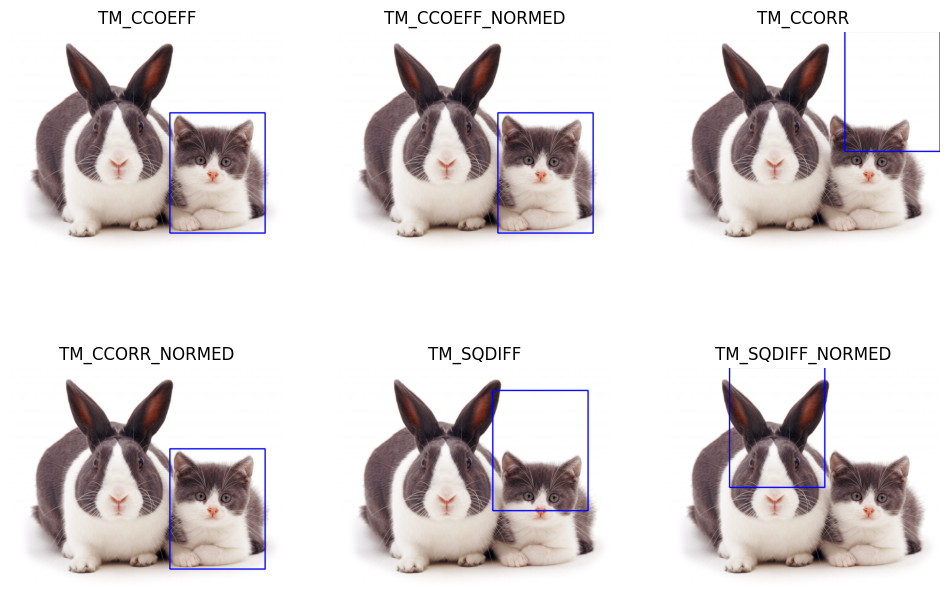

In [4]:
methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR, cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]
method_names = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR', 'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']

plt.figure(figsize=(12, 8))
for i, method in enumerate(methods):
    plt.subplot(2, 3, i + 1)
    result_image = findBestMatch(image, template, method)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(method_names[i])
    plt.axis('off')

plt.show()


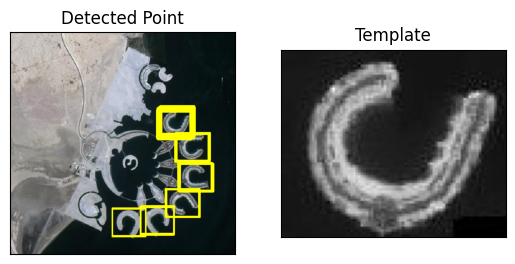

In [5]:
detect_and_highlight_template_matches('./dataset/bahrain.jpg', './dataset/bahrain-template.jpg')

## Edge Detection

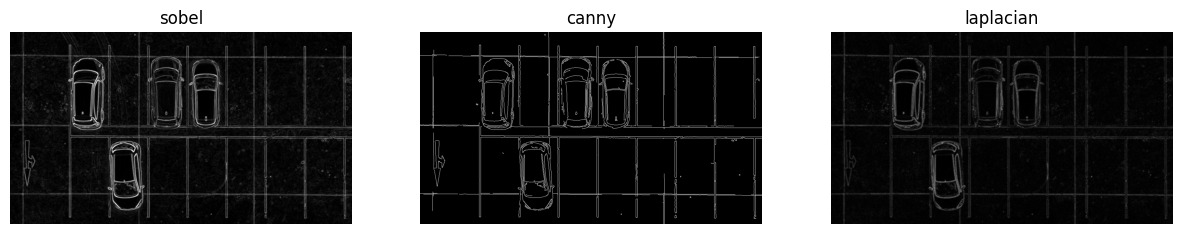

In [6]:
img_park = cv2.imread('./dataset/car-park.jpg')

methods = ['sobel', 'canny', 'laplacian']

edge_images = [apply_edge_detection(img_park, method) for method in methods]

plot_images_with_titles(edge_images, methods)

## Corner Detection

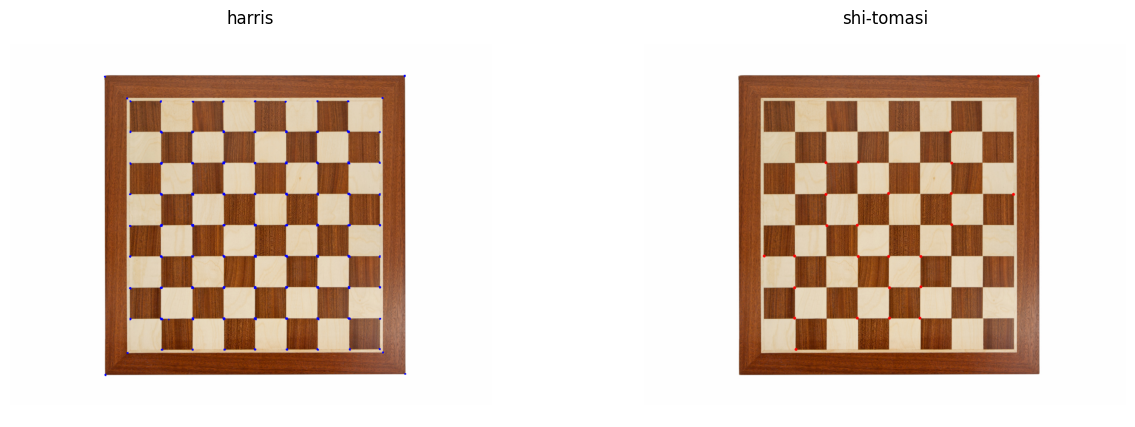

In [7]:
img_chess = load_image('./dataset/chess-board.jpg')
methods = ['harris', 'shi-tomasi']
corner_images = [apply_corner_detection(img_chess.copy(), method) for method in methods]
plot_images_with_titles(corner_images, methods)

In [8]:
file_path = './dataset/sudoku.jpg'
img_sudoku = cv2.imread(file_path)

number of Hough lines: 33


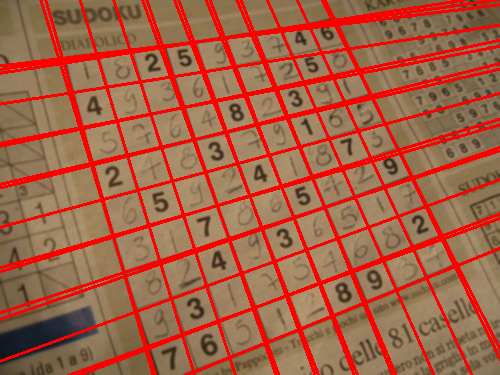

In [9]:
filter = False

gray = cv2.cvtColor(img_sudoku,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,90,150,apertureSize = 3)
kernel = np.ones((3,3),np.uint8)
edges = cv2.dilate(edges,kernel,iterations = 1)
kernel = np.ones((5,5),np.uint8)
edges = cv2.erode(edges,kernel,iterations = 1)
lines = cv2.HoughLines(edges,1,np.pi/180,150)

if not lines.any():
    print('No lines were found')
    exit()

if filter:
    rho_threshold = 15
    theta_threshold = 0.1

    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

print('number of Hough lines:', len(lines))

filtered_lines = []

if filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

for line in filtered_lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img_sudoku,(x1,y1),(x2,y2),(0,0,255),2)

cv2_imshow(img_sudoku)

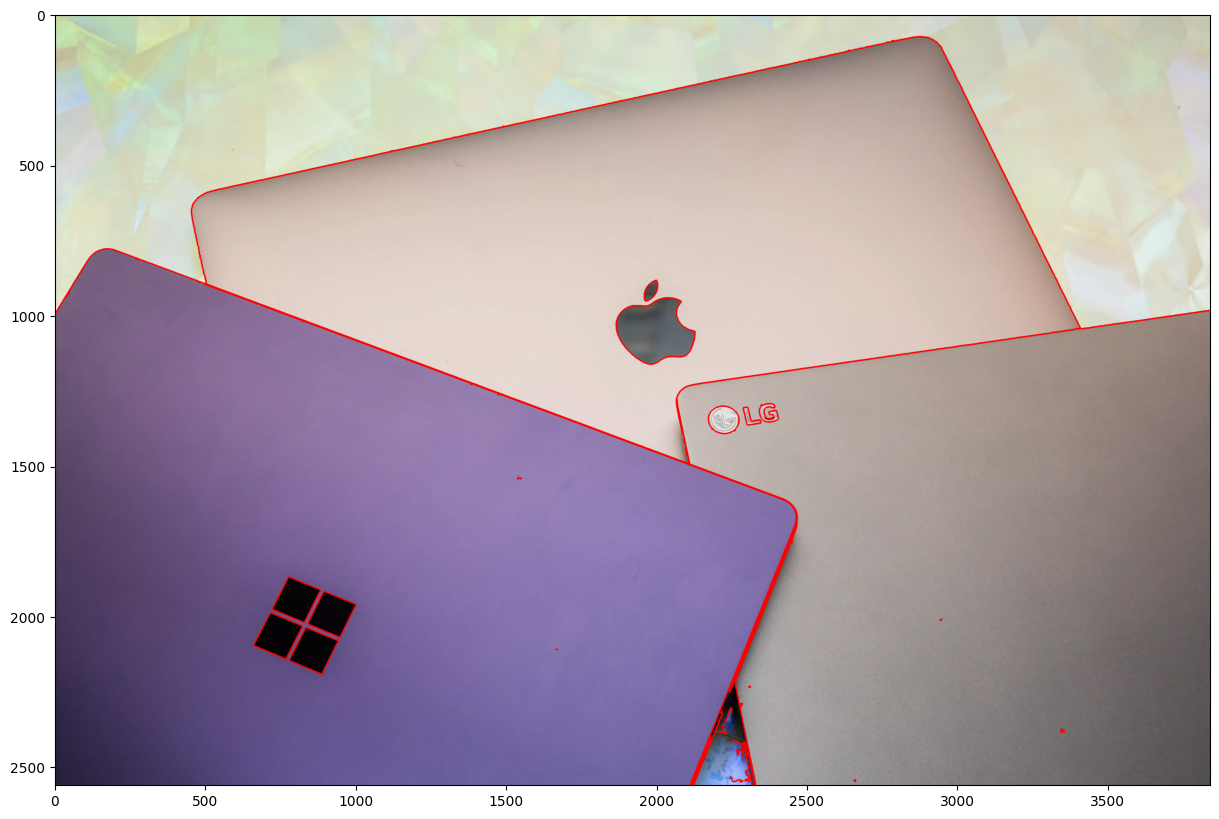

In [10]:
image = load_image('dataset/laptop.jpg')
original_image = image.copy()

edged = cv2.Canny(image, 30, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(image, contours, -1, (0,0,255), 3)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Praktikum KTP

In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

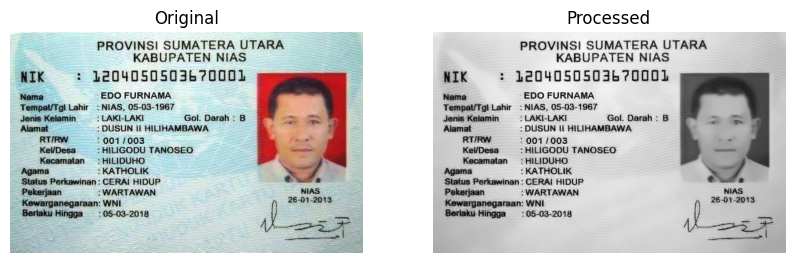

In [15]:
ktp_image = load_image('ktp.png')
ktp_denoised = cv2.fastNlMeansDenoisingColored(ktp_image, None, h=7)
ktp_image_gray = cv2.cvtColor(ktp_denoised, cv2.COLOR_RGB2GRAY)
compare_images(ktp_image, ktp_image_gray, cmap='gray')

In [16]:
ret, threshed = cv2.threshold(ktp_image_gray, 127, 255, cv2.THRESH_TRUNC)

In [18]:
import pytesseract

text1 = pytesseract.image_to_data(threshed,output_type='data.frame')
text2 = pytesseract.image_to_string(threshed, lang="ind")

In [23]:
text = text1[text1.conf != -1]
lines = text.groupby('block_num')['text'].apply(list)
conf = text.groupby(['block_num'])['conf'].mean()


from pytesseract import Output

img = threshed

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


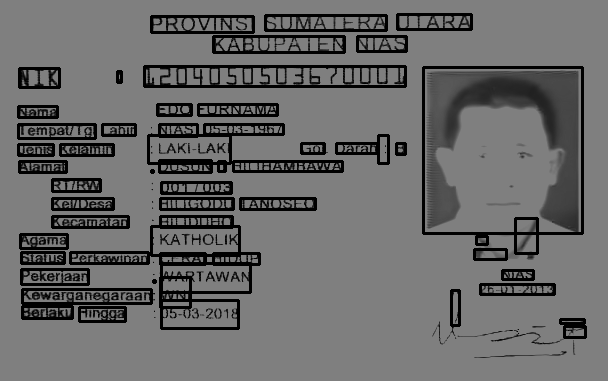

In [24]:
n_boxes = len(text1['text'])


for i in range(n_boxes):
    if int(text1['conf'][i]) > 20:
        (x, y, w, h) = (text1['left'][i], text1['top'][i], text1['width'][i], text1['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)

In [25]:
print(text2)

NIK 1 12010505036?0001

Nama
Tempat/Tgl Lahir
Jenis Kelamin
Alamat
RTIRW
Kel/Desa
Kecamatan
Agama
Status Perkawinan
Pekerjaan
Kewarganegaraan:
Berlaku Hingga

:DUSUN II HILIHAMBAWA

PROVINSI SUMATERA UTARA
KABUPATEN NIAS

EDO FURNAMA
NIAS, 05-03-1967
LAKI-LAKI Gol. Darah : B

0011003
HILIGODU TANOSEO
HILIDUHO
KATHOLIK » /
CERAI HIDUP €oba
: WARTAWAN NIAS
WNI | 26-01-2013
/

   

05-03-2018 —

-
l

